This Jupyter Notebook file will be our central location for analysis on Jyutping. The analysis in this notebook will help facilitate the planning of HKIME.

## Jyutping Dictionary Initialization

In [6]:
from matplotlib import pyplot as plt
from jyutping_dict import JyutpingDict
import numpy as np

In [7]:
jd = JyutpingDict()

Dictionary of 701 Jyutpings mapping to 38643 different Chinese characters created


## Statistics

In [8]:
print("Prefix Frequencies")
print(jd.prefix_freq)
print("Suffix Frequencies")
print(jd.suffix_freq)
print("2-gram Frequencies")
print(jd.twoGram_freq)

Prefix Frequencies
{'j': 3386, 'd': 1571, 'c': 2721, 'z': 3377, 'k': 1594, 'n': 1946, 'm': 1579, 'g': 3205, 's': 2827, 't': 1360, 'l': 3130, 'h': 2188, 'f': 1372, 'a': 736, 'p': 984, 'w': 1425, 'b': 1393, 'o': 363, 'e': 7, 'u': 15, 'i': 6}
Suffix Frequencies
{'u': 5720, 't': 2287, 'm': 2094, 'a': 901, 'g': 5555, 'i': 7049, 'p': 1245, 'n': 5714, 'o': 904, 'k': 3425, 'e': 291}
2-gram Frequencies
{'ja': 680, 'au': 2115, 'do': 298, 'ou': 1358, 'ca': 851, 'at': 1050, 'zi': 1043, 'im': 631, 'kw': 370, 'wa': 1474, 'aa': 5003, 'ng': 6684, 'ji': 1407, 'ga': 1618, 'ap': 772, 'di': 365, 'in': 2597, 'si': 850, 'to': 395, 'za': 1020, 'ma': 601, 'an': 3160, 'no': 128, 'lo': 625, 'du': 150, 'un': 2713, 'iu': 1010, 'ho': 515, 'ha': 858, 'ki': 200, 'it': 547, 'ai': 2390, 'da': 568, 'sa': 792, 'ke': 290, 'eo': 1821, 'oi': 1676, 'ei': 1263, 'fe': 70, 'jy': 720, 'yu': 1872, 'fa': 583, 'fu': 539, 'co': 448, 'ge': 299, 'ze': 404, 'hu': 148, 'la': 852, 'am': 1390, 'so': 325, 'oe': 929, 'en': 761, 'ju': 271, 

In the following graph, it is very clear which letters are more likely to be prefixes and which are more likely to be suffixes. So, this could be a potentially simple way to dissect Jyutping strings.

Text(0.5, 1.0, 'Suffix Frequencies')

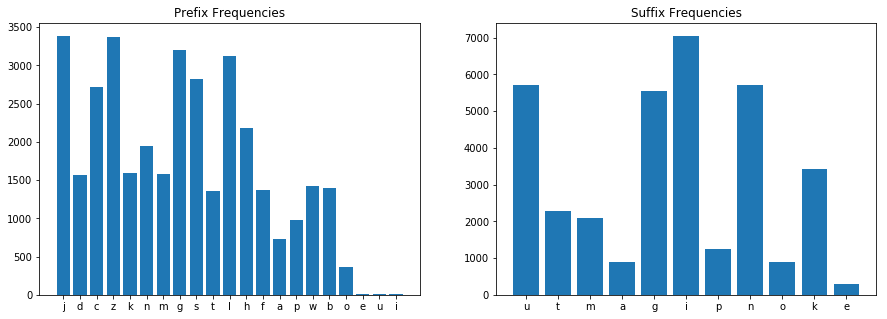

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].bar(jd.prefix_freq.keys(), jd.prefix_freq.values())
ax[0].set_title("Prefix Frequencies")
ax[1].bar(jd.suffix_freq.keys(), jd.suffix_freq.values())
ax[1].set_title("Suffix Frequencies")

## Disambiguating Jyutping Boundaries

An intelligent IME should be able to determine the boundaries of the individual Jyutpings for each character.
For example, we wish to seperate "Jyutping (粤拼)" into ["jyut (粤)", "ping (拼)"].

### Goals:
- Seperate Fuzzy Jyutping (模糊拼音 in regular pinyin IME's)
- Seperate Incomplete Jyutping ("dg" -> "點解")

### Problem Statement
For a given input Jyutping string corresponding to two words $S$, define the event $s_i$ as being $S[i]$ is the last character of the Jyutping corresponding to the first word and $S[i + 1]$ is the first character for the next word. Thus, the problem can be expressed as finding $\max_{i} \mathbb{P}(s_i)$.



### Head and Tail 2-gram Approach
In the following, we will define $g_k$ as the 2-gram $S[k: k + 2]$. We will also let $H(g_k)$ and $T(g_k)$ denote the events that $g_k$ is a head 2-gram and a tail 2-gram respectively. 

It is reasonable to assume that $H$ and $T$ are independent. We will also make the assumption that $$\max_{i} \mathbb{P}(s_i) = \max_i \mathbb{P}(g_{i - 1} \text{is a tail 2-gram} \cap g_{i + 1}
\text{is a head 2-gram}),$$
which we can simplify to
$$\max_i \mathbb{P}(s_i) = \max_i \mathbb{P}(T(g_{i-1}) \cap H(g_{i+1})) = \max_i \mathbb{P}(T(g_{i-1}))\mathbb{P}(H(g_{i+1})).$$

In [39]:
def ht2gram_boundary(jyutdict, jyutping_input):
    # TODO: Edge cases for short inputs causing index OOB
    # and case that no valid split could be found
    
    def get_2gram(g_k):
        return jyutping_input[g_k : min(g_k + 2, len(jyutping_input))]
    
    def calculate_prob(s_i):
        head_p = jyutdict.calc_twoGramTail_prob(get_2gram(s_i - 1))
        tail_p = jyutdict.calc_twoGramHead_prob(get_2gram(s_i + 1))
        return head_p * tail_p
    
    idxs = len(jyutping_input) - 1
    probs = [calculate_prob(i) for i in range(idxs)]
    max_i = max(range(idxs), key=calculate_prob)
        
    return max_i, jyutping_input[:max_i + 1], jyutping_input[max_i + 1:]

In [40]:
# 粵拼、一點、丁丁、叉燒
jyutping_list = ["jyutping", "jatdim", "dingding", "caasiu"]
for j_input in jyutping_list:
    _, first, second = ht2gram_boundary(jd, j_input)
    print(first, second)

jyut ping
jat dim
ding ding
caa siu
